COMBINING MY IDEAS WITH THE STRUCTURE OF OTHER NOTEBOOKS I HAVE SEEN TO CREATE THE BEST RESULTS ALONG WITH THE LEAST AMOUNT
OF CODE. THANKS TO STUDENT HUB ANSWERS FOR IDEAS. https://github.com/jay-thakur/Advanced-Lane-Finding/blob/master/P2.ipynb SPECIFICALLY

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [230]:
#Create a function that will undistort images for us
def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

#Create a function for binary transformation
def transform(image, b_thresh=(145,200), l_thresh=(215,255), s_thresh=(170,255)):
    #Create b_channel image
    b_channel = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)[:,:,2]
    #Create l_channel image
    l_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]
    #Create s_channel image
    #s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    #Create b_channel binary image
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    #Create l_channel binary image
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    #Create s_channel binary image
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #Combine them
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary
    
#Create a function to transform the perspective to top down
def perspective(combined_binary):
    img_size = (combined_binary.shape[1], combined_binary.shape[0])

    src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    ret, Minv = cv2.invert(M)
    
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, binary_warped

#Create a function that finds the pixels of each lane line and returns them
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#Define a function that fits a polynomial to each lane line (right and left) using pixel points we found
def fit_polynomial(binary_warped):
    # Find our lane pixels first    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img, left_fit, right_fit

#Create a function to determine ROC
def curvature_func(left_fitx, right_fitx, ploty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty/2)*ym_per_pix
    
    # Fit a second order polynomial to pixel positions in each lane line    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = (left_curverad + right_curverad) / 2
    
    dist_from_center = (640 - (left_fitx[-1] + right_fitx[-1])//2)*xm_per_pix
    
    return curvature, dist_from_center

#Create a function to plot the lane on the original undistorted image
def plot_lane(image, binary_warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    return cv2.addWeighted(image, 1, newwarp, 0.3, 0)

#Create a function that acts as our video processing pipeline does the same thing we did with images but
#Will now run on video
def video_pipeline(image):     
    
    undistorted = undistort(image, mtx, dist)
    
    BTHRESH = (145,200)
    LTHRESH = (215,255)
    STHRESH = (170,255)
    
    combined_binary = transform(undistorted, BTHRESH, LTHRESH, STHRESH)

    M, Minv, binary_warped = perspective(combined_binary)
    
    leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img, left_fit, right_fit = fit_polynomial(binary_warped)
    
    curv, dev = curvature_func(left_fitx, right_fitx, ploty)
    
    result = plot_lane(image, binary_warped, Minv, left_fitx, right_fitx, ploty)
    
    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfTextCurve = (10,100)
    bottomLeftCornerOfTextDeviation = (10,200)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2

    cv2.putText(result,'Radius of Curvature(m): '+ str(curv), 
        bottomLeftCornerOfTextCurve, 
        font, 
        fontScale,
        fontColor,
        lineType)

    if dev < 0:
        direction = 'left'
    else:
        direction = 'right'
        
    cv2.putText(result,'Deviation(m): '+ str(dev) + ' ' + str(direction) + ' of center', 
        bottomLeftCornerOfTextDeviation, 
        font, 
        fontScale,
        fontColor,
        lineType)

    #return np.hstack((final_output, out_img))
    return result

#Create function that processes the video
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below         
    # you should return the final output (image where lines are drawn on lanes)
    return video_pipeline(image)

In [231]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

Text(0.5,1,'Undistorted Image')

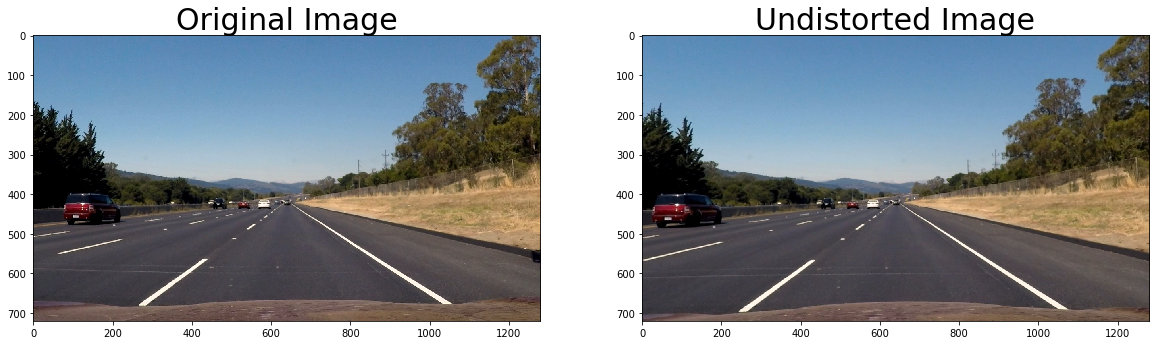

In [232]:
#Try this function out on an image
image = mpimg.imread("test_images/straight_lines2.jpg")

undistorted = undistort(image, mtx, dist)
# Display Original & Undistorted Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

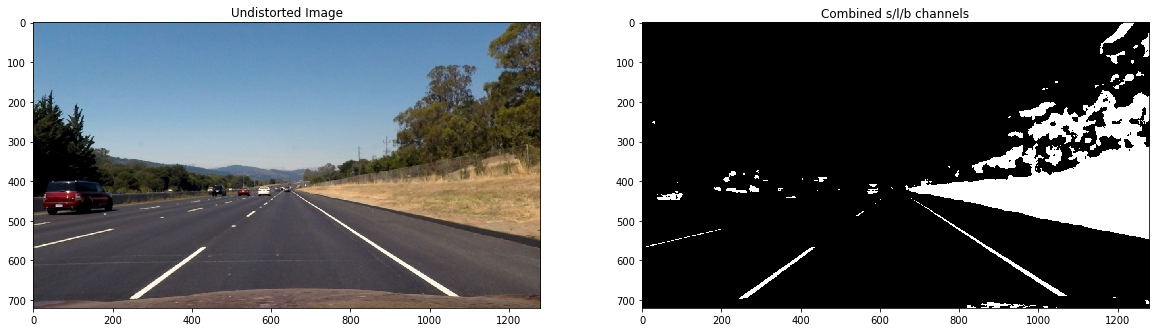

In [233]:
original_image = np.copy(undistorted)

combined_binary = transform(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image')
ax1.imshow(original_image)

ax2.set_title('Combined s/l/b channels')
ax2.imshow(combined_binary, cmap='gray')


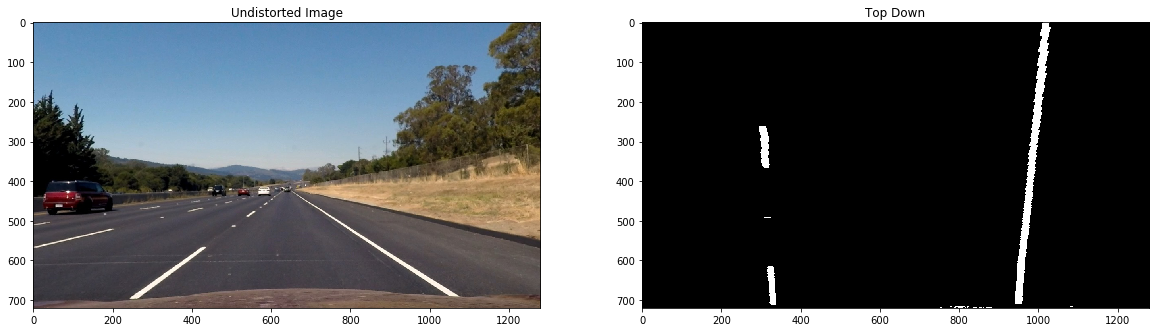

In [234]:
M, Minv, binary_warped = perspective(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image')
ax1.imshow(original_image)

ax2.set_title('Top Down')
ax2.imshow(binary_warped, cmap='gray')

[  2.81136962e-05   2.54683806e-02   2.97425722e+02]
[ -5.48357182e-06  -9.92749307e-02   1.01825871e+03]


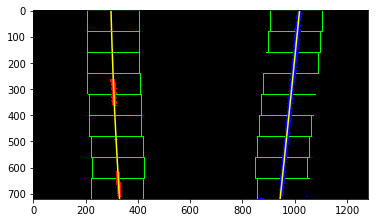

In [235]:
leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img, left_fit, right_fit = fit_polynomial(binary_warped)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
print(left_fit)
print(right_fit)
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

In [236]:
curvature, dev = curvature_func(left_fitx, right_fitx, ploty)
print("Radius of Curvature(m)): %f" % curvature)
print("Deviation(m): %f "%dev)

Radius of Curvature(m)): 17898.813526
Deviation(m): 0.015857 


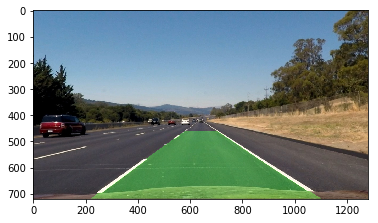

In [237]:
result = plot_lane(original_image, binary_warped, Minv, left_fitx, right_fitx, ploty)
plt.imshow(result)

In [238]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:02<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 48s, sys: 2.88 s, total: 2min 51s
Wall time: 5min 5s


In [239]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))